In [172]:
import numpy as np
import matplotlib.pyplot as plt

import aero_model
import dynamic
import atmosphere
# Modèle d'avion
aircraft = aero_model.Airbus_A319_100()

aircraft.set_options(stall=True, buffeting=True, wave_drag=True)

import numpy as np
import matplotlib.pyplot as plt

In [196]:
import numpy as np
import matplotlib.pyplot as plt
atm = atmosphere.AtmosphereISA()

def optimize_for_range_existing_trim_mass_cg(aero_m, altp, mass, cg_pct_mac, plot=False):
    """
    Optimisation de Fn/V en utilisant graceful_trim avec masse et centrage variables.
    Retourne : sol_opt, tas_opt, solutions
    """
    aero_m.m = mass
    rxg = cg_pct_mac / 100.0  
    aero_m.set_balance(rxg)

    speeds = np.linspace(0.5, 0.9, 50)
    fn_over_v = []
    solutions = []

    for mach in speeds:
        tas = atm.tas_from_mach_altg(mach, altp)
        try:
            aoa, dtrim, dthr = dynamic.graceful_trim(aero_m, altp, tas)
        except Exception:
            aoa, dtrim, dthr = np.nan, np.nan, np.nan

        if not np.isnan(aoa):
            try:
                res = dynamic.get_trim_level_flight(aero_m, altp, tas, use_saturations=True)
                if res is not None:
                    fu = res["fu"][0]  
                    fn = fu   
                    fn_over_v.append(fn / tas)
                    solutions.append(res)
                else:
                    fn_over_v.append(np.nan)
                    solutions.append(None)
            except Exception:
                fn_over_v.append(np.nan)
                solutions.append(None)
        else:
            fn_over_v.append(np.nan)
            solutions.append(None)

    fn_over_v = np.array(fn_over_v)

    if np.all(np.isnan(fn_over_v)):
        return None, None, solutions
        
    idx_opt = np.nanargmin(fn_over_v)
    sol_opt = solutions[idx_opt]
    tas_opt = speeds[idx_opt]

    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(tas_opt, fn_over_v[idx_opt], color='red', label="Optimal")
        plt.plot(speeds, fn_over_v, label=r"$F_n/V$")
        plt.xlabel("Nombre de mach")
        plt.ylabel(r"$F_n/V$ (N·s/m)")
        plt.title(f"Vitesse optimale à paramètres fixés (Masse={mass/1000:.1f} t, Centrage={cg_pct_mac:.1f} %MAC, Altitude={altp:.0f} m)")
        plt.grid()
        plt.legend()
        plt.show()

    return sol_opt, tas_opt, solutions


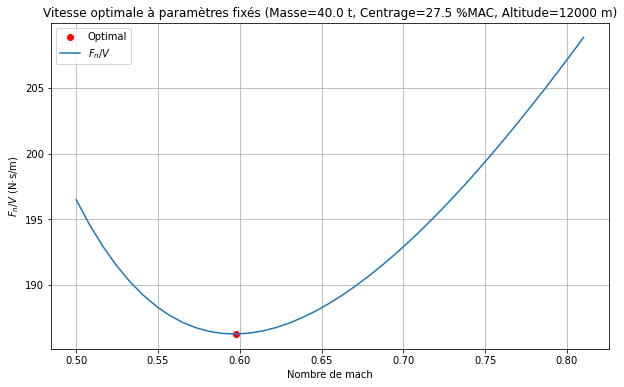

({'dthr': [0.6141637688720789, 'no_dim'], 'aoa': [0.010843684226666792, 'deg'], 'dtrim': [-0.08138380143953242, 'deg'], 'dm': [0.0, 'deg'], 'cz': [0.6532544272209229, 'no_dim'], 'cx': [0.054776828745994516, 'no_dim', 4], 'cm': [-5.551115123125783e-17, 'no_dim', 4], 'fu': [32864.422032034316, 'daN'], 'lod': [11.925743825918204, 'no_dim']}, 0.5979591836734695, [{'dthr': [0.5158503445540579, 'no_dim'], 'aoa': [0.06407186678779592, 'deg'], 'dtrim': [-0.11595141908305498, 'deg'], 'dm': [0.0, 'deg'], 'cz': [0.9307230249601064, 'no_dim'], 'cx': [0.06896177368979613, 'no_dim', 4], 'cm': [-5.551115123125783e-17, 'no_dim', 4], 'fu': [28986.84677851858, 'daN'], 'lod': [13.496216456767556, 'no_dim']}, {'dthr': [0.5215806488548098, 'no_dim'], 'aoa': [0.0584486916379353, 'deg'], 'dtrim': [-0.1122995985780113, 'deg'], 'dm': [0.0, 'deg'], 'cz': [0.9014104606642693, 'no_dim'], 'cx': [0.06722257853022605, 'no_dim', 4], 'cm': [-5.551115123125783e-17, 'no_dim', 4], 'fu': [29175.912788831676, 'daN'], 'lod'

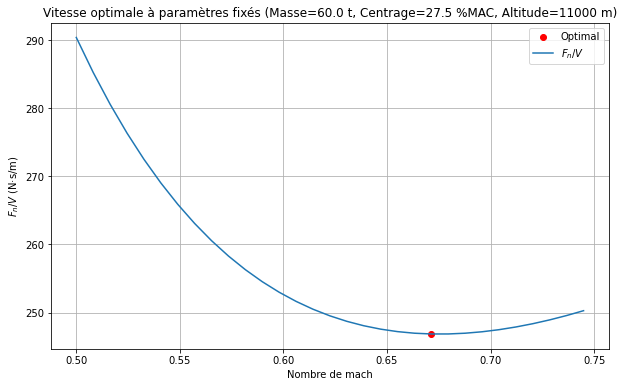

In [ ]:
aircraft = aero_model.Airbus_A319_100()
altp = 12000      # altitude en m
mass = 40000     # masse en kg
cg = 27.5        # centrage en %MAC

sol_opt = optimize_for_range_existing_trim_mass_cg(aircraft, altp, mass, cg, True)
altp = 11000      # altitude en m
mass = 60000     # masse en kg
cg = 27.5        # centrage en %MAC

sol_opt = optimize_for_range_existing_trim_mass_cg(aircraft, altp, mass, cg, True)

In [180]:
atm =atmosphere.AtmosphereISA()

def atmosphere_properties(atm, altitude, tas):
    """
    Calcule sigma, Mach et densité à partir de l'altitude (m) et TAS (m/s).
    """
    pamb, tamb = atm.atmosphere(altitude)
    rho = atm.air_density(pamb, tamb)
    sigma = rho / atm.rho0
    vsnd = atm.sound_speed(tamb)
    mach = tas / vsnd
    
    return sigma, mach, rho

import numpy as np
import scipy.optimize

def ceiling_altitude(aero_model, atm, tas, dthr, cx, h_min=5000, h_max=20000):
    """
    Trouve l'altitude où poussée = traînée pour une masse donnée.
    - aero_model : ton modèle d'avion (ex: aircraft)
    - atm : ton modèle AtmosphereISA
    - mass : masse actuelle de l'avion (kg)
    - tas_law : fonction qui donne TAS en fonction de l'altitude (m)
    - h_min / h_max : bornes de recherche d'altitude (m)
    """
    
    g = atm.g
    
    def delta_thrust(h):
        pamb, tamb = atm.atmosphere(h)
        rho = atm.air_density(pamb, tamb)
        vsnd = atm.sound_speed(tamb)
        mach = tas / vsnd
        sigma = rho / atm.rho0
        
        q = 0.5 * rho * tas**2
        drag = q * aero_model.w.s * cx
        thrust = aero_model.thrust(sigma, mach, dthr)  # Plein gaz
        
        return thrust - drag

    # Recherche de la racine
    h_opt = scipy.optimize.brentq(delta_thrust, h_min, h_max)
    return h_opt


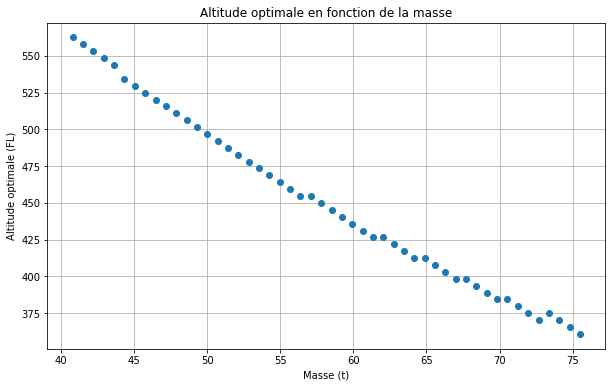

In [204]:
masses = np.linspace(aircraft.oem, aircraft.mtom, 50)
altps = np.linspace(11000, 18000, 50)
cg = 25  # exemple

atm = atmosphere.AtmosphereISA()

altitude_optimale = []
tas_opt_list = []

for mass in masses:
    fn_over_v_list = []
    tas_at_each_alt = []

    for altp in altps:
        sol_opt, tas_opt, solutions = optimize_for_range_existing_trim_mass_cg(aircraft, altp, mass, cg, plot=False)

        if sol_opt is not None:
            fu = sol_opt["fu"][0]  # daN
            fn = fu * 10  # N
            fn_over_v = fn / tas_opt
            fn_over_v_list.append(fn_over_v)
            tas_at_each_alt.append(tas_opt)
        else:
            fn_over_v_list.append(np.nan)
            tas_at_each_alt.append(np.nan)

    fn_over_v_array = np.array(fn_over_v_list)
    tas_at_each_alt = np.array(tas_at_each_alt)

    if np.all(np.isnan(fn_over_v_array)):
        altitude_optimale.append(np.nan)
        tas_opt_list.append(np.nan)
        continue

    idx_opt = np.nanargmin(fn_over_v_array)
    altitude_optimale.append(altps[idx_opt])
    tas_opt_list.append(tas_at_each_alt[idx_opt])

# Conversion en FL
altitude_optimale_FL = np.array(altitude_optimale) / 30.48

plt.figure(figsize=(10, 6))
plt.plot(masses/1000, altitude_optimale_FL, "o")
plt.xlabel("Masse (t)")
plt.ylabel("Altitude optimale (FL)")
plt.title("Altitude optimale en fonction de la masse")
plt.grid()
plt.show()


